In [59]:
import pandas as pd
import os

ruta_sisaire = "Datos/SISAIRE"

# SISAIRE 
def cargar_sisaire(ruta):
    archivos = [f for f in os.listdir(ruta) if f.endswith(('.xlsx', '.csv'))]
    lista_dfs = []
    for archivo in archivos:
        path = os.path.join(ruta, archivo)
        if archivo.endswith('.csv'):
            df = pd.read_csv(path)
        else:
            df = pd.read_excel(path)
        df["fuente"] = "SISAIRE"
        df["archivo_origen"] = archivo
        lista_dfs.append(df)
    df_sisaire = pd.concat(lista_dfs, ignore_index=True)
    print(f"SISAIRE: {len(archivos)} archivos cargados. Forma total: {df_sisaire.shape}")
    print("Columnas detectadas:", list(df_sisaire.columns))
    return df_sisaire


sisaire = cargar_sisaire(ruta_sisaire)


SISAIRE: 24 archivos cargados. Forma total: (2622273, 9)
Columnas detectadas: ['Estacion', 'Fecha inicial', 'Fecha final', 'NO2', 'fuente', 'archivo_origen', 'O3', 'SO2', 'CO']


In [60]:
import pandas as pd
import numpy as np
import os

ruta_iboca = "Datos/IBOCA"
columnas_finales = ["Fecha & Hora", "Location", "Concentraci√≥n", "NowCast", "IBOCA"]

# --- funci√≥n auxiliar para limpiar valores num√©ricos ---
def to_num(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if s.lower().startswith("sin data"):
        return np.nan
    s = s.replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

# --- funci√≥n principal para procesar UN archivo ---
def procesar_iboca(path):
    try:
        df_raw = pd.read_excel(path, header=None)
    except Exception as e:
        print(f"[ERROR] {path}: {e}")
        return pd.DataFrame(columns=columnas_finales)

    # Fechas (columna A)
    df_fechas = df_raw.iloc[7:, [0]].copy()
    df_fechas.columns = ["Fecha & Hora"]
    df_fechas["Fecha & Hora"] = pd.to_datetime(df_fechas["Fecha & Hora"], errors="coerce", dayfirst=True)

    bloques = []
    n_cols = df_raw.shape[1]

    for start_col in range(1, n_cols, 3):
        if start_col + 2 >= n_cols:
            break

        # Lugar est√° en la fila 5 (√≠ndice 4) de la 1¬™ columna del bloque
        lugar = df_raw.iat[4, start_col] if 4 < df_raw.shape[0] else None
        if not isinstance(lugar, str) or lugar.strip() == "" or lugar.strip().lower() == "nan":
            continue
        lugar = lugar.strip()

        vals = df_raw.iloc[7:, start_col:start_col+3].copy()
        vals.columns = ["Concentraci√≥n", "NowCast", "IBOCA"]

        for c in ["Concentraci√≥n", "NowCast", "IBOCA"]:
            vals[c] = vals[c].apply(to_num)

        df_block = pd.concat([df_fechas.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
        df_block.insert(1, "Location", lugar)
        df_block = df_block.dropna(subset=["Concentraci√≥n", "NowCast", "IBOCA"], how="all")

        if not df_block.empty:
            bloques.append(df_block)

    if not bloques:
        return pd.DataFrame(columns=columnas_finales)

    df_final = pd.concat(bloques, ignore_index=True)
    df_final = df_final[columnas_finales]

    print(f"[OK] {os.path.basename(path)} -> {df_final.shape[0]} filas")
    return df_final


# --- recorrer carpeta entera ---
todos = []
archivos = [f for f in os.listdir(ruta_iboca) if f.lower().endswith(('.xlsx', '.xls')) and not f.startswith("~$")]

for archivo in sorted(archivos):
    path = os.path.join(ruta_iboca, archivo)
    df_arch = procesar_iboca(path)
    if not df_arch.empty:
        df_arch["Archivo origen"] = archivo
        todos.append(df_arch)

# --- concatenar todo ---
if todos:
    df_iboca_total = pd.concat(todos, ignore_index=True)
    print("\nDataset IBOCA consolidado:", df_iboca_total.shape)
    print("Fechas:", df_iboca_total["Fecha & Hora"].min(), "‚Üí", df_iboca_total["Fecha & Hora"].max())
    print("Estaciones √∫nicas:", df_iboca_total["Location"].nunique())
else:
    df_iboca_total = pd.DataFrame(columns=columnas_finales)
    print("\nNo se generaron datos v√°lidos.")



[OK] IBOCA-PM10-2020-1.xlsx -> 79019 filas
[OK] IBOCA-PM10-2020-2.xlsx -> 58957 filas
[OK] IBOCA-PM10-2021-1.xlsx -> 67916 filas
[OK] IBOCA-PM10-2021-2.xlsx -> 74140 filas
[OK] IBOCA-PM10-2022-1.xlsx -> 71172 filas
[OK] IBOCA-PM10-2022-2.xlsx -> 79109 filas
[OK] IBOCA-PM10-2023-1.xlsx -> 79004 filas
[OK] IBOCA-PM10-2023-2.xlsx -> 67919 filas
[OK] IBOCA-PM10-2023-3.xlsx -> 12821 filas
[OK] IBOCA-PM10-2024-1.xlsx -> 81081 filas
[OK] IBOCA-PM10-2024-2.xlsx -> 56678 filas
[OK] IBOCA-PM10-2025-1.xlsx -> 67224 filas
[OK] IBOCA-PM10-2025-2.xlsx -> 37207 filas
[OK] IBOCA-PM25-2020-1.xlsx -> 55891 filas
[OK] IBOCA-PM25-2020-2.xlsx -> 60455 filas
[OK] IBOCA-PM25-2021-1.xlsx -> 67916 filas
[OK] IBOCA-PM25-2021-2.xlsx -> 74053 filas
[OK] IBOCA-PM25-2022-1.xlsx -> 70874 filas
[OK] IBOCA-PM25-2022-2.xlsx -> 79800 filas
[OK] IBOCA-PM25-2023-1.xlsx -> 80251 filas
[OK] IBOCA-PM25-2023-2.xlsx -> 66228 filas
[OK] IBOCA-PM25-2023-3.xlsx -> 13564 filas
[OK] IBOCA-PM25-2024-1.xlsx -> 79019 filas
[OK] IBOCA-

In [61]:
df_iboca_total.head(10)

Fecha & Hora Location  Concentraci√≥n  NowCast   IBOCA  \
0 2024-01-01 00:00:00  Bolivia           26.0    24.16   76.36   
1 2024-01-01 01:00:00  Bolivia           23.0    23.58   75.14   
2 2024-01-01 02:00:00  Bolivia           18.0    20.79   69.27   
3 2024-01-01 03:00:00  Bolivia           13.0    16.89   61.08   
4 2024-01-01 04:00:00  Bolivia           24.0    20.45   68.56   
5 2024-01-01 05:00:00  Bolivia           23.0    21.73   71.24   
6 2024-01-01 06:00:00  Bolivia           29.0    25.36   78.89   
7 2024-01-01 07:00:00  Bolivia           37.0    31.18   91.14   
8 2024-01-01 08:00:00  Bolivia           38.0    34.59   98.31   
9 2024-01-01 09:00:00  Bolivia           46.0    40.30  112.82   

           Archivo origen  
0  IBOCA-PM10-2020-1.xlsx  
1  IBOCA-PM10-2020-1.xlsx  
2  IBOCA-PM10-2020-1.xlsx  
3  IBOCA-PM10-2020-1.xlsx  
4  IBOCA-PM10-2020-1.xlsx  
5  IBOCA-PM10-2020-1.xlsx  
6  IBOCA-PM10-2020-1.xlsx  
7  IBOCA-PM10-2020-1.xlsx  
8  IBOCA-PM10-2020-1.xlsx  
9  IBOCA-PM10-2020-1.xlsx

In [62]:
print("Dimensiones del dataset:", df_iboca_total.shape)
print("\nTipos de datos:")
print(df_iboca_total.dtypes)
print("\nNulos por columna:")
print(df_iboca_total.isna().sum())


Dimensiones del dataset: (1641445, 6)

Tipos de datos:
Fecha & Hora      datetime64[ns]
Location                  object
Concentraci√≥n            float64
NowCast                  float64
IBOCA                    float64
Archivo origen            object
dtype: object

Nulos por columna:
Fecha & Hora       1440
Location              0
Concentraci√≥n     29129
NowCast           14800
IBOCA             16513
Archivo origen        0
dtype: int64


In [63]:
print("\nRango de fechas:")
print(df_iboca_total["Fecha & Hora"].min(), " ‚Üí ", df_iboca_total["Fecha & Hora"].max())

# Frecuencia aproximada
df_iboca_total["delta_horas"] = df_iboca_total["Fecha & Hora"].diff().dt.total_seconds() / 3600
print("\nFrecuencias m√°s comunes (en horas):")
print(df_iboca_total["delta_horas"].value_counts().head())



Rango de fechas:
2020-01-01 00:00:00  ‚Üí  2025-09-22 18:00:00

Frecuencias m√°s comunes (en horas):
delta_horas
1.0    1629528
2.0       3995
3.0       1728
4.0        801
5.0        800
Name: count, dtype: int64


In [64]:
print("\nN√∫mero de estaciones:", df_iboca_total["Location"].nunique())
print("\nTop estaciones por n√∫mero de registros:")
print(df_iboca_total["Location"].value_counts().head(10))



N√∫mero de estaciones: 27

Top estaciones por n√∫mero de registros:
Location
Guaymaral        97291
MinAmbiente      97226
CDAR             96581
Las Ferias       95924
Fontibon         95888
Kennedy          95075
San Cristobal    92746
Puente Aranda    90760
Tunal            90178
Suba             87545
Name: count, dtype: int64


In [65]:
print("\n--- Estad√≠sticas de Concentraci√≥n ---")
print(df_iboca_total["Concentraci√≥n"].describe())

print("\n--- Estad√≠sticas de NowCast ---")
print(df_iboca_total["NowCast"].describe())

print("\n--- Estad√≠sticas de IBOCA ---")
print(df_iboca_total["IBOCA"].describe())



--- Estad√≠sticas de Concentraci√≥n ---


count    1.612316e+06
mean     2.299171e+01
std      2.224942e+01
min      0.000000e+00
25%      9.000000e+00
50%      1.800000e+01
75%      3.100000e+01
max      9.693000e+03
Name: Concentraci√≥n, dtype: float64

--- Estad√≠sticas de NowCast ---
count    1.626645e+06
mean     2.394111e+01
std      6.359827e+01
min      1.000000e-02
25%      1.110000e+01
50%      1.900000e+01
75%      3.000000e+01
max      4.898000e+03
Name: NowCast, dtype: float64

--- Estad√≠sticas de IBOCA ---
count    1.624932e+06
mean     4.939879e+01
std      6.667500e+01
min      1.000000e-02
25%      2.625000e+01
50%      4.600000e+01
75%      6.488000e+01
max      4.412000e+03
Name: IBOCA, dtype: float64


In [66]:
print("\nCorrelaciones:")
print(df_iboca_total[["Concentraci√≥n", "NowCast", "IBOCA"]].corr())



Correlaciones:
               Concentraci√≥n   NowCast     IBOCA
Concentraci√≥n       1.000000  0.199725  0.169481
NowCast             0.199725  1.000000  0.941054
IBOCA               0.169481  0.941054  1.000000


In [67]:
print("Dimensiones:", sisaire.shape)
print("\nTipos de datos:")
print(sisaire.dtypes)

print("\nValores nulos:")
print(sisaire.isna().sum())


Dimensiones: (2622273, 9)

Tipos de datos:
Estacion           object
Fecha inicial      object
Fecha final        object
NO2               float64
fuente             object
archivo_origen     object
O3                float64
SO2               float64
CO                float64
dtype: object

Valores nulos:
Estacion                0
Fecha inicial           0
Fecha final             0
NO2               1916958
fuente                  0
archivo_origen          0
O3                1936079
SO2               2094477
CO                1919305
dtype: int64


In [68]:
sisaire["fecha_inicial"] = pd.to_datetime(sisaire["Fecha inicial"], errors="coerce")
sisaire["fecha_final"]   = pd.to_datetime(sisaire["Fecha final"], errors="coerce")

# Duraci√≥n en horas
sisaire["duracion_horas"] = (sisaire["fecha_final"] - sisaire["fecha_inicial"]).dt.total_seconds() / 3600

print(sisaire["duracion_horas"].describe())


count    2.622273e+06
mean     9.823621e-01
std      3.088853e-02
min      0.000000e+00
25%      9.833333e-01
50%      9.833333e-01
75%      9.833333e-01
max      9.833333e-01
Name: duracion_horas, dtype: float64


In [69]:
print("N√∫mero de estaciones:", sisaire["Estacion"].nunique())
print("\nTop estaciones por cantidad de registros:")
print(sisaire["Estacion"].value_counts().head(10))


N√∫mero de estaciones: 20

Top estaciones por cantidad de registros:
Estacion
PUENTE ARANDA                 177475
CENTRO DE ALTO RENDIMIENTO    175842
P_CAMI - FONTIB√ìN             172757
KENNEDY                       172098
SUBA                          166081
TUNAL                         163695
EL JAZM√çN                     157106
USAQUEN                       155396
CIUDAD BOL√çVAR                151850
"USME"                        149122
Name: count, dtype: int64


In [70]:
contaminantes = ["NO2", "O3", "SO2", "CO"]
print("\n--- Estad√≠sticas descriptivas ---")
print(sisaire[contaminantes].describe())



--- Estad√≠sticas descriptivas ---
                 NO2             O3            SO2             CO
count  705315.000000  686194.000000  527796.000000  702968.000000
mean       29.164204      23.985524       4.683595     697.881220
std        18.033334      21.350903       6.642913     538.462583
min         0.000000       0.000000       0.000000       0.000000
25%        14.855160       6.353000       1.833000     343.470000
50%        26.701680      19.031400       2.909000     572.450000
75%        40.052520      35.752000       5.237200     889.052063
max       259.948000     225.041000     515.864000   13738.800000



Promedios anuales por estaci√≥n:
    a√±o                    Estacion        NO2         O3        SO2  \
0  2020                      "USME"  33.870038  24.924867   8.705450   
1  2020                     BOLIVIA  30.732731        NaN   2.469439   
2  2020                        BOSA  20.696334  26.151430   5.552440   
3  2020        CARVAJAL - SEVILLANA  46.700288  18.758828  10.653043   
4  2020  CENTRO DE ALTO RENDIMIENTO  24.437183  31.807635   2.419776   

            CO  
0   562.462181  
1   544.657138  
2   419.346930  
3  1192.911935  
4   610.645337  


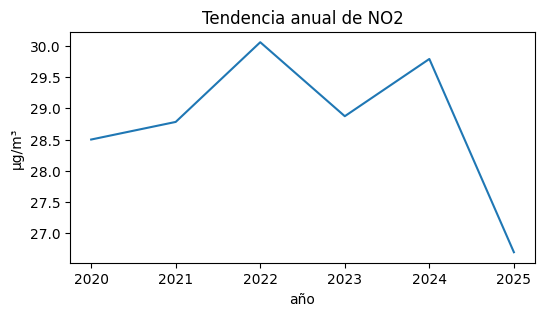

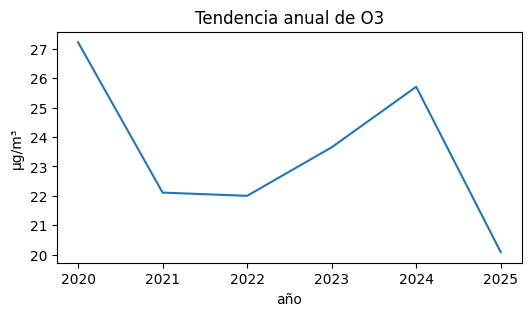

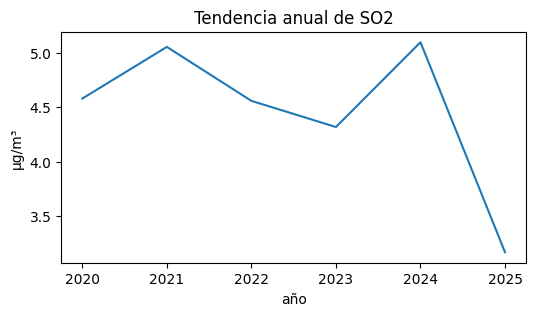

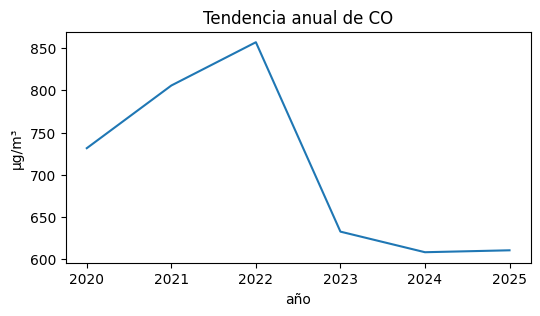

In [71]:
sisaire["a√±o"] = sisaire["fecha_inicial"].dt.year
mensual = sisaire.groupby(["a√±o", "Estacion"])[contaminantes].mean().reset_index()

print("\nPromedios anuales por estaci√≥n:")
print(mensual.head())

import matplotlib.pyplot as plt

for gas in contaminantes:
    mensual.groupby("a√±o")[gas].mean().plot(title=f"Tendencia anual de {gas}", figsize=(6,3))
    plt.ylabel("¬µg/m¬≥")
    plt.show()



üìÖ Promedios diarios por estaci√≥n (muestra):
        Fecha              Location  Concentraci√≥n    NowCast       IBOCA
0  2020-01-01                  CDAR      15.333333  14.600000   55.362083
1  2020-01-01  Carvajal - Sevillana      39.826087  36.875000  104.158333
2  2020-01-01              Fontibon      26.083333  23.791667   75.139167
3  2020-01-01             Guaymaral      15.000000  13.766667   53.571667
4  2020-01-01               Kennedy      45.541667  42.366667  117.769167

üìà Rango de fechas: 2020-01-01 ‚Üí 2025-09-22


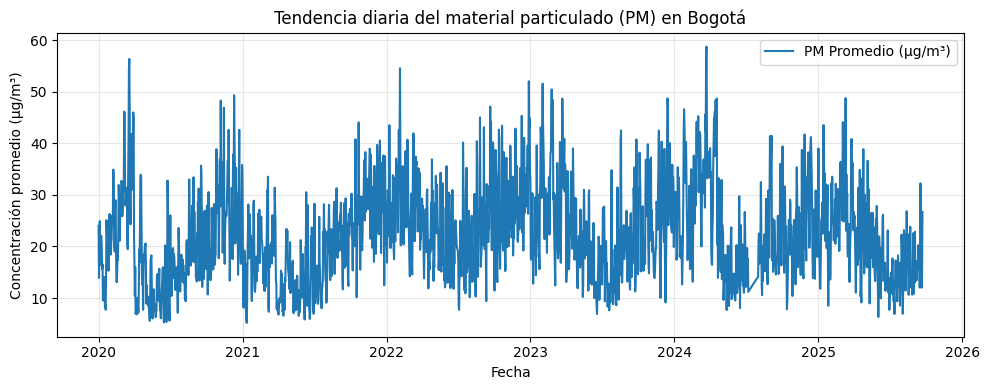

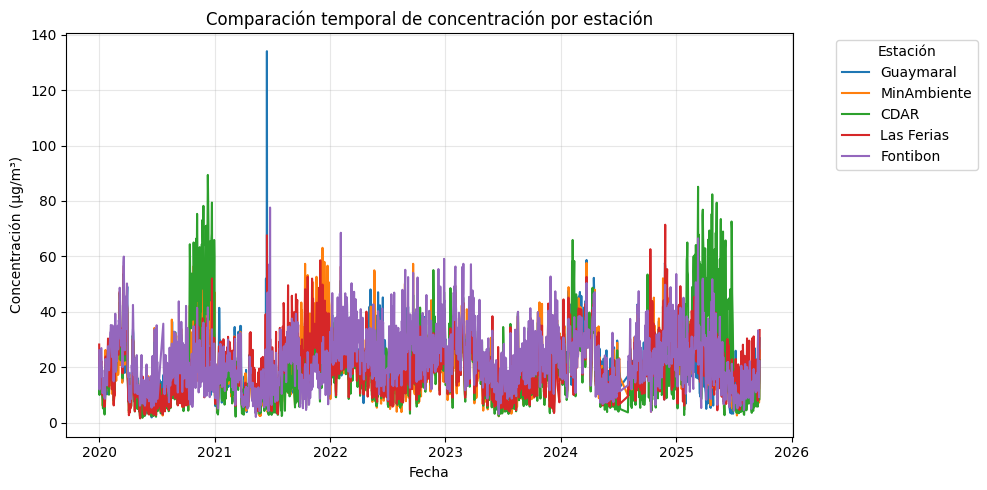

<Figure size 800x400 with 0 Axes>

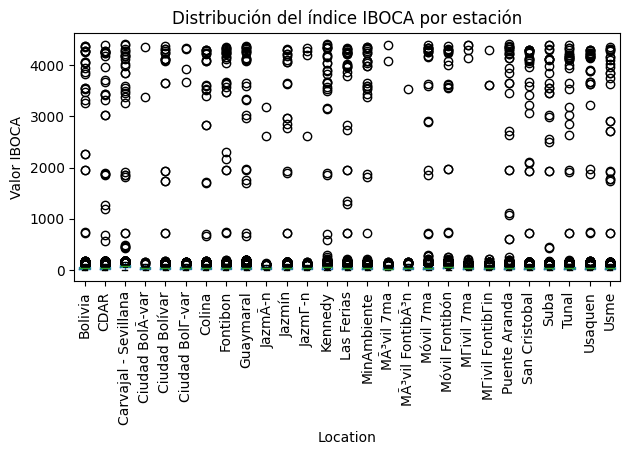

In [ ]:

import matplotlib.pyplot as plt

# Convertir a fecha (d√≠a sin hora)
df_iboca_total["Fecha"] = df_iboca_total["Fecha & Hora"].dt.date

# --- Promedio diario por estaci√≥n ---
df_diario = (
    df_iboca_total
    .groupby(["Fecha", "Location"])[["Concentraci√≥n", "NowCast", "IBOCA"]]
    .mean()
    .reset_index()
)

print("\nüìÖ Promedios diarios por estaci√≥n (muestra):")
print(df_diario.head())

# --- Promedio diario global (todas las estaciones) ---
df_diario_global = (
    df_iboca_total
    .groupby("Fecha")[["Concentraci√≥n", "NowCast", "IBOCA"]]
    .mean()
    .reset_index()
)

print("\nüìà Rango de fechas:", df_diario_global["Fecha"].min(), "‚Üí", df_diario_global["Fecha"].max())

# --- Gr√°fico 1: tendencia temporal promedio de concentraci√≥n ---
plt.figure(figsize=(10, 4))
plt.plot(df_diario_global["Fecha"], df_diario_global["Concentraci√≥n"], label="PM Promedio (¬µg/m¬≥)", color="#1f77b4")
plt.title("Tendencia diaria del material particulado (PM) en Bogot√°")
plt.xlabel("Fecha")
plt.ylabel("Concentraci√≥n promedio (¬µg/m¬≥)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Gr√°fico 2: comparaci√≥n por estaci√≥n ---
top_estaciones = df_iboca_total["Location"].value_counts().head(5).index.tolist()
df_top = df_diario[df_diario["Location"].isin(top_estaciones)]

plt.figure(figsize=(10, 5))
for loc in top_estaciones:
    subset = df_top[df_top["Location"] == loc]
    plt.plot(subset["Fecha"], subset["Concentraci√≥n"], label=loc)

plt.title("Comparaci√≥n temporal de concentraci√≥n por estaci√≥n")
plt.xlabel("Fecha")
plt.ylabel("Concentraci√≥n (¬µg/m¬≥)")
plt.legend(title="Estaci√≥n", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gr√°fico 3: Distribuci√≥n de IBOCA por estaci√≥n (caja) ---
plt.figure(figsize=(8, 4))
df_iboca_total.boxplot(column="IBOCA", by="Location", grid=False, rot=90)
plt.title("Distribuci√≥n del √≠ndice IBOCA por estaci√≥n")
plt.suptitle("")  
plt.ylabel("Valor IBOCA")
plt.tight_layout()
plt.show()
